# Notebook para probar cosas

### Librerias que seran utilizadas

* sklearn
* tensorflow
* keras
* smart-open
* matplotlib
* seaborn
* numpy

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.utils import shuffle as shfle # necesario para desordenar nuestros datos iniciales de manera consistente

%matplotlib inline

Using TensorFlow backend.


### Pasos a seguir

* practicar tutorial del profe
* definir forma de acceder a los datos  (**LISTO**)
* definir una primera forma de obtener los descriptores del texto   (**LISTO**) -> usando countVectorizer
* definir una segunda forma de obtener los descriptores del texto
* definir pre procesamiento de los datos (ordenamiento, limpieza, escalado, etc)  (**LISTO**)
* definir un regresor para obtener los descriptores de la imagen en base a descriptores de texto (**LISTO**)
* entrenar utilizando pocas neuronas escondidas para no demorar tanto y testear resultados (**LISTO**)
* realizar validaciones sobre la red, verificar sobre ajuste y metricas disponibles, iterar cuanto sea necesario.
* entrenar para la red mas grande.
* definir el calculador de distancias y la mertrica que se utilizara para realizar las busquedas
* realizar pruebas sobre los resultados y crear graficos
* concluir y generar un informe bonito

### Bibliografia
paginas desde donde sacaremos ideas, es para tener un registro

* http://queirozf.com/entries/evaluation-metrics-for-ranking-problems-introduction-and-examples
* https://medium.com/datadriveninvestor/building-neural-network-using-keras-for-regression-ceee5a9eadff
* https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction
* https://datascienceplus.com/keras-regression-based-neural-networks/
* https://machinelearningmastery.com/save-load-keras-deep-learning-models/
* https://keras.io/callbacks/  <-- pal early stopping puede servir (si es que lo implementas)
* https://keras.io/models/sequential/ <-- es parte del de arriba
* https://keras.rstudio.com/articles/tutorial_overfit_underfit.html  <-- puede servir por si tienes dudas del overfitting
* tutorial del profe

vayamos agregando los avances aqui, cosa que cuando uno quiera avanzar algo el otro pueda usar su avance y asi.

Todos los archivos python que agregues metelos en /src, las funciones de un archivo se importan asi:

    from src.foo import function
    
en /develop meti el codigo de MLP en tensorflow y del java del profe, creo que no los necesitaremos pero los deje por si acaso. Cualquier cosa que creas que podriamos utilizar pero no estes seguro agregala a develop

### accesso a los datos

### IMPORTANTE:
los datos guardalos de esta forma:
(estamos en la carpeta raiz de nuestro proyecto)

* ./data/train_data -> carpeta que contiene a los archivos .txt y al .bin de train


* ./data/test_A_data -> carpeta que contiene a los archivos .txt y al .bin de test


In [2]:
# probemos el codigo del profe para leer datos
# cargando descriptores de imagenes
# import numpy
# import os

# def load_file(file_names, file_vectors, num_vectors, vector_dimensions):
#     assert os.path.isfile(file_names), "no existe archivo " + file_names
#     assert os.path.isfile(file_vectors), "no existe archivo " + file_vectors
#     print("leyendo " + file_names)
#     names = [line.strip() for line in open(file_names)]
#     assert num_vectors == len(names), "no cuadra largo archivo " + len(names)
#     print("leyendo " + file_vectors)
#     mat = numpy.fromfile(file_vectors, dtype=numpy.float32)
#     vectors = numpy.reshape(mat, (num_vectors, vector_dimensions))
#     print(str(num_vectors) + " vectores de largo " + str(vector_dimensions))
#     return (names, vectors)

# def load_train_vectors():
#     return load_file("./data/train_data/train_images_names.txt", "./data/train_data/train_images_vectors.bin", 20000, 2048)
    
# def load_test_vectors():
#     return load_file("test_A_images_names.txt", "test_A_images_vectors.bin", 1000, 2048)

# (train_names, train_vectors) = load_train_vectors()
# # (test_names, test_vectors) = load_test_vectors()
# print(np.shape(train_names), np.shape(train_vectors))
# print("Imagen \"" + train_names[0] + "\" tiene descriptor visual " + str(train_vectors[0]) + " de dimension " + str(len(train_vectors[0])))

In [3]:
# cargar captions de train
# def load_captions(file_captions):
#     assert os.path.isfile(file_captions), "no existe archivo " + file_captions
#     return [line.strip().split("\t") for line in open(file_captions, encoding='utf-8')]

# # test_captions = load_file("test_A_captions.txt")
# train_captions = load_captions("./data/train_data/train_captions.txt")
# print(np.shape(train_captions))
# for i in range(6):
#     print("Imagen \"" + train_captions[i][0] + "\" tiene caption \"" + train_captions[i][1] + "\"")

* tengo 20000 vectores de largo 2048, es decir la matriz de entrenamiento y sera de shape (20000, 2048)
* pero tengo 5 captions por cada imaganes y por tanto, 5 captions por cada descriptor de imagen, entonces mis shapes seran:

    - (100000, $\alpha$) para la matriz de entrenamiento de entrada (X)
    - (100000, 2048) para la matriz de entrenamiento de resultados (y)

* donde $\alpha$ esta dado por el descriptor de texto que creemos. El profe sugirio que seria de largo 1000

### obtener descriptores de texto

* countVectorizer usando ngram_range (1, 1) es igual a un unigrama, que es directamente el metodo de bag of words
* tf-idf: aun no se lo que es ...
* word embedding: es posible implementar esto dentro de la red, pero requiere usar convoluciones dentro de la regresion y para ello se necesita GPU y tal vez agregue mucha complejidad.

ahora usare solo bag of words (countVectorizing)

In [4]:
# obtengo solo los captions (asumo que los textos vienen ordenados)
# train_captions = np.array(train_captions)
# train_texts = train_captions[:,1]

In [5]:
# from sklearn.feature_extraction.text import CountVectorizer

# vectorizer = CountVectorizer(lowercase=False,ngram_range=(1,1),max_df=0.8,min_df=0.01,binary=True)
# vectorizer.fit(train_texts)

# X_train = vectorizer.transform(train_texts)
# # X_test  = vectorizer.transform(texts_test)

# print("Entrenamiento: {}".format(X_train.shape))
# # print("Test: {}".format(X_test.shape))
# X_train

### ordenemos un poco todo

In [6]:
def load_file(file_names, file_vectors, num_vectors, vector_dimensions):
    assert os.path.isfile(file_names), "no existe archivo " + file_names
    assert os.path.isfile(file_vectors), "no existe archivo " + file_vectors
    print("leyendo " + file_names)
    names = [line.strip() for line in open(file_names)]
    assert num_vectors == len(names), "no cuadra largo archivo " + len(names)
    print("leyendo " + file_vectors)
    mat = np.fromfile(file_vectors, dtype=np.float32)
    vectors = np.reshape(mat, (num_vectors, vector_dimensions))
    print(str(num_vectors) + " vectores de largo " + str(vector_dimensions))
    return (names, vectors)
    
def load_captions(file_captions):
    assert os.path.isfile(file_captions), "no existe archivo " + file_captions
    return [line.strip().split("\t") for line in open(file_captions, encoding='utf-8')]

# crearemos una clase que simplifique todo el proceso de adquirir los datos
class DataHandler(object):
    def __init__(self, root_folder="./"):
        self.root = root_folder
        self.vectors_dimension = 2048
        self._data = {}
        
    def _load(self, names_file, vectors_file, captions_file, num_vectors):
        (names, vectors) = load_file(names_file, vectors_file, num_vectors, self.vectors_dimension)
        captions = load_captions(captions_file)
        vectors_for_captions = []
        for vector in vectors:
            for _ in range(5):
                vectors_for_captions.append(vector)
        return names, np.array(vectors_for_captions), np.array(captions)
        

    def load_train(self, folder=""):
        if len(folder) > 0 and folder[0] != '/':
            folder = '/' + folder
        names_file = "{}{}/train_images_names.txt".format(self.root, folder)
        captions_file = "{}{}/train_captions.txt".format(self.root, folder)
        vectors_file = "{}{}/train_images_vectors.bin".format(self.root, folder)
        return self._load(names_file, vectors_file, captions_file, 20000)
    
    def load_test(self, folder=""):
        if len(folder) > 0 and folder[0] != '/':
            folder = '/' + folder
        names_file = "{}{}/test_A_images_names.txt".format(self.root, folder)
        captions_file = "{}{}/test_A_captions.txt".format(self.root, folder)
        vectors_file = "{}{}/test_A_images_vectors.bin".format(self.root, folder)
        return self._load(names_file, vectors_file, captions_file, 1000)
    
    def get_data_count_vectorizer(self, train_folder="/train_data", test_folder="/test_A_data", **kwargs):
        train_names, train_vectors, train_image_captions = self.load_train(folder=train_folder)
        test_names, test_vectors, test_image_captions = self.load_test(folder=test_folder)
        
        print("doing vectorization with CountVectorizer")
        train_captions = train_image_captions[:,1]
        test_captions = test_image_captions[:,1]
        vectorizer = CountVectorizer(lowercase=False,ngram_range=(1,1),max_df=0.8,min_df=0.01,binary=True)
        print("fitting bag of words ...", end="")
        vectorizer.fit(train_captions)
        print("done")
        
        print("getting vectors transforms ...", end="")
        train_text_descriptors = vectorizer.transform(train_captions)
        test_text_descriptors = vectorizer.transform(test_captions)
        print("done")
        
        # esto podria ser util
#         self._data.update({"train_names": train_names, 
#                            "train_text_descriptors": train_text_descriptors,
#                            "train_image_descriptors": train_vectors,
#                            "test_names": test_names, 
#                            "test_text_descriptors": test_text_descriptors, 
#                            "test_image_descriptors": test_vectors})

        return train_text_descriptors, test_text_descriptors, train_vectors, test_vectors
    

In [7]:
# luego bastaria con hacer

data = DataHandler(root_folder="./data")
X_train, X_test, y_train, y_test = data.get_data_count_vectorizer()
print("shapes")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

leyendo ./data/train_data/train_images_names.txt
leyendo ./data/train_data/train_images_vectors.bin
20000 vectores de largo 2048
leyendo ./data/test_A_data/test_A_images_names.txt
leyendo ./data/test_A_data/test_A_images_vectors.bin
1000 vectores de largo 2048
doing vectorization with CountVectorizer
fitting bag of words ...done
getting vectors transforms ...done
shapes
X_train: (100000, 153)
y_train: (100000, 2048)
X_test: (5000, 153)
y_test: (5000, 2048)


### Regresor con keras
la idea del regresor es poder guardar el modelo en disco asi cuando se entrene una red muy brijida la tengamos guardadita, para eso se necesita el h5py

In [21]:
class Regressor(object):
    
    def __init__(self, input_dim, output_dim, n_layers=2, layer_size=2048, scale_data=False):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self._n = n_layers
        self._size = layer_size
        self.optimizer = "adam"
        self.loss = "mean_squared_error"
        self.metrics = ["mae", "accuracy"]
        self.model = None
        self.sc_X = None
        self.sc_y = None
        self.scaled = scale_data
        
    def build(self):
        self.model = Sequential()
        self.model.add(Dense(self._size, input_dim=self.input_dim, kernel_initializer='normal', activation='relu'))
        i = self._n - 1
        while i > 0:
            self.model.add(Dense(self._size, activation='relu'))
            i -= 1
        self.model.add(Dense(self.output_dim, activation='linear'))
        self.model.summary()
        self.model.compile(loss=self.loss, optimizer=self.optimizer, metrics=self.metrics)
        
    def fit(self, X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, shuffle=True, scale=None):
        # shuffle data
        X_train, y_train = shfle(X_train, y_train, random_state=0)
        # necesitamos desordenar los datos antes para que la particion de validacion si tome datos variados.
        
        if scale is not None:
            self.scaled = scale
        if self.scaled:
            self.sc_X = MaxAbsScaler()
            self.sc_X.fit(X_train)
            X_train = self.sc_X.transform(X_train)
            self.sc_y = MaxAbsScaler()
            self.sc_y.fit(y_train)
            y_train = self.sc_y.transform(y_train)
        results=self.model.fit(X_train,y_train, epochs=epochs, 
                               validation_split=validation_split,shuffle=shuffle,
                               batch_size=batch_size)
        return results
    
    def save(self, model_file="model"):
        # serialize model to JSON
        model_json = self.model.to_json()
        with open("./model/" + model_file + ".json", "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        self.model.save_weights("./model/" + model_file + ".h5")
        print("Saved model to disk")
    
        
    def load(self, model_file="model"):
        # load json and create model
        json_file = open("./model/" + model_file + '.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        self.model = model_from_json(loaded_model_json)
        # load weights into new model
        self.model.load_weights("./model/" + model_file + ".h5")
        print("Loaded model from disk")
        self.model.compile(loss=self.loss, optimizer=self.optimizer, metrics=self.metrics)
    
    def evaluate(self, X_test, y_test):
        if self.scaled:
            X_test = self.sc_X.transform(X_test)
            y_test = self.sc_y.transform(y_test)
        score = self.model.evaluate(X_test, y_test, verbose=True)
        print("%s: %.2f" % (self.model.metrics_names[1], score[1]))
        print("%s: %.2f" % (self.model.metrics_names[0], score[0]))
        print("%s: %.2f%%" % (self.model.metrics_names[2], score[2]*100))
        return score
        
    def get_model(self):
        return self.model
    
    def set_scaled(self, X_train, y_train):
        elf.sc_X = MaxAbsScaler()
        self.sc_X.fit(X_train)
        self.sc_y = MaxAbsScaler()
        self.sc_y.fit(y_train)
        self.scaled = True
        
    def predict(self, X):
        # aqui probablemente debamos normalizar X
        X_scaled = self.sc_X.transform(X)
        return self.model.predict(X_scaled)
        # y probablemente debamos des-normalizar X e y_predicho
        y = self.sc_y.inverse_transform(y_scaled) 
        X_reversed = self.sc_X.inverse_transform(X_scaled)
        assert X == X_reversed
        return y
    
def plot_metrics(history):
    print(history.history.keys())
    fig, ax = plt.subplots(1, 3, figsize=(16, 4))
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('model loss')
    ax[0].set_ylabel('loss')
    ax[0].set_xlabel('epoch')
    ax[0].legend(['train', 'validation'], loc='upper left')

    ax[1].plot(history.history['acc'])
    ax[1].plot(history.history['val_acc'])
    ax[1].set_title('model acc')
    ax[1].set_ylabel('acc')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['train', 'validation'], loc='upper left')

    ax[2].plot(history.history['mean_absolute_error'])
    ax[2].plot(history.history['val_mean_absolute_error'])
    ax[2].set_title('model MSE')
    ax[2].set_ylabel('MSE')
    ax[2].set_xlabel('epoch')
    ax[2].legend(['train', 'validation'], loc='upper left')
    return fig, ax

#### Experimentos sobre la red
tenemos que hacer 2 grandes experimentos a priori:
* entrenar con los datos directos
* entrenar con los datos normalizados

en ambos usemos una NN de 2 capas internas pero con pocas neuronas, puede ser unas 100
La idea es entrenar y botener los loss, MSE y accuracy para train y validation.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 100)               15400     
_________________________________________________________________
dense_11 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_12 (Dense)             (None, 2048)              206848    
Total params: 232,348
Trainable params: 232,348
Non-trainable params: 0
_________________________________________________________________
Train on 80000 samples, validate on 20000 samples
Epoch 1/10
80000/80000 [==============================] - 7s 85us/step - loss: 0.6082 - mean_absolute_error: 0.4766 - acc: 0.1229 - val_loss: 0.5781 - val_mean_absolute_error: 0.4621 - val_acc: 0.1618
Epoch 2/10
80000/80000 [==============================] - 6s 76us/step - loss: 0.5735 - mean_absolute_error: 0.4631 - acc: 0.1683 - val_loss: 0.5703 

[0.5636493322372437, 0.4627211977958679, 0.1658]

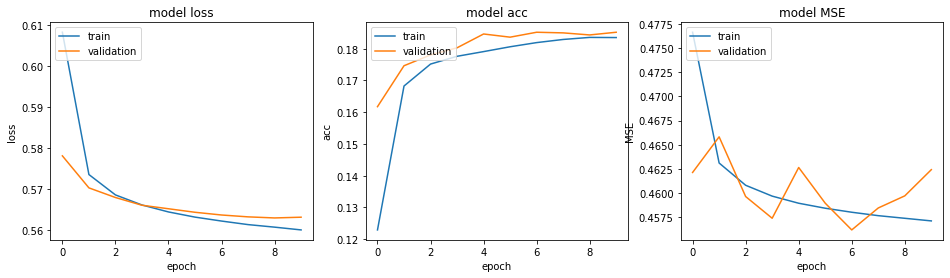

In [24]:
# esto se debiese usar simplemente asi: (ejemplo con un regresor pequeño)
reg = Regressor(X_train.shape[1], y_train.shape[1], n_layers=2, layer_size=100)
reg.build()
history = reg.fit(X_train, y_train, epochs=10, validation_split=0.2)
plot_metrics(history)
# guardamos el modelo por seguridad
reg.save(model_file="model1")
# y luego podemos evaluar este modelo en el dataset de test
reg.evaluate(X_test, y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 100)               15400     
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_9 (Dense)              (None, 2048)              206848    
Total params: 232,348
Trainable params: 232,348
Non-trainable params: 0
_________________________________________________________________
Train on 80000 samples, validate on 20000 samples
Epoch 1/10
80000/80000 [==============================] - 7s 88us/step - loss: 0.0050 - mean_absolute_error: 0.0450 - acc: 0.0333 - val_loss: 0.0048 - val_mean_absolute_error: 0.0440 - val_acc: 0.0447
Epoch 2/10
80000/80000 [==============================] - 6s 80us/step - loss: 0.0048 - mean_absolute_error: 0.0439 - acc: 0.0440 - val_loss: 0.0048 

[0.004817980595678091, 0.04364308735132218, 0.0516]

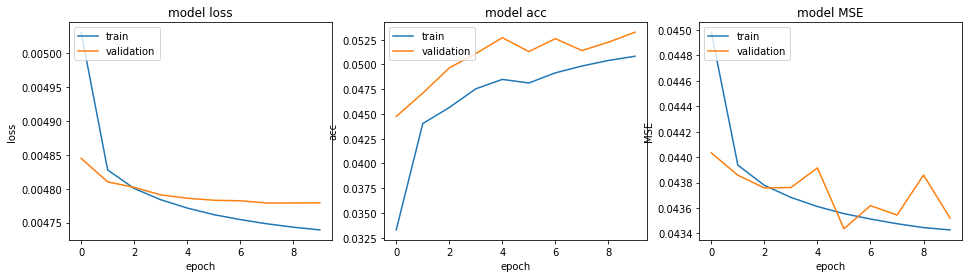

In [23]:
# esto se debiese usar simplemente asi: (ejemplo con un regresor pequeño)
reg2 = Regressor(X_train.shape[1], y_train.shape[1], n_layers=2, layer_size=100)
reg2.build()
history2 = reg2.fit(X_train, y_train, epochs=10, validation_split=0.2, scale=True)
plot_metrics(history2)
# guardamos el modelo por seguridad
reg2.save(model_file="model1_scaled")
# y luego podemos evaluar este modelo en el dataset de test
reg2.evaluate(X_test, y_test)

#### Experimento para una NN mucho mas grande
la idea es ver si realmente usar una NN como la que recomendo el profe da mejores resultados.

el profe dijo, usar 2 capas escondidas, cada una de tamaño 2048.

En mi computador, cada epoca tardo serca de 10 min. No termine el test. Desconozco cuantas epocas son suficientes, hay que probar con redes pequeñas y encontrar el numero de pecosas optimas (el punto desde donde ocurre el overffit)

In [ ]:
# ESTO PUEDE TARDAR BASTANTE!!!
reg3 = Regressor(X_train.shape[1], y_train.shape[1], n_layers=2, layer_size=2048)
reg3.build()
history3 = reg3.fit(X_train, y_train, epochs=10, validation_split=0.2, scale=True)
plot_metrics(history3)
# guardamos el modelo por seguridad
reg3.save(model_file="model_full_size")
# y luego podemos evaluar este modelo en el dataset de test
reg3.evaluate(X_test, y_test)